<a href="https://colab.research.google.com/github/eko-andri-prasetyo/Belajar-Fundamental-Deep-Learning/blob/main/sentiment_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Analisis Sentimen — Target Bintang 5 (Dicoding)

Notebook ini dibuat agar memenuhi **kriteria utama** dan **saran penilaian bintang 5**:
- Data hasil scraping mandiri (>= 3.000; disarankan >= 10.000)
- Minimal **3 kelas** (negatif/netral/positif)
- **3 eksperimen** dengan minimal **2 kombinasi** berbeda (algoritma / split / fitur)
- Menggunakan **Deep Learning** (Keras + opsi IndoBERT)
- Menyediakan **inference** (output label kategorikal)
- Notebook **harus di-run** sebelum submit (output terlihat)

> Tips bintang 5: pastikan setidaknya 1 eksperimen mendapatkan **akurasi train & test > 92%**.
> Cara paling “aman” biasanya: **fine-tune IndoBERT** + dataset >= 10k + distribusi kelas seimbang.

In [1]:
!pip -q install transformers datasets evaluate accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [2]:
# Jika di Google Colab (disarankan), jalankan:
# !pip -q install -r requirements.txt

import os, re, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_PATH = "dataset_playstore.csv"  # pastikan file ini hasil scraping mandiri sebelum submit

## 1) Load data + cek kolom

In [3]:
df = pd.read_csv(DATA_PATH)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
df.head()

Rows: 12000
Columns: ['text', 'rating', 'label', 'at', 'reviewId', 'appId']


,text,rating,label,at,reviewId,appId
0,sangat suka,5,positif,2025-12-31 07:32:08,f90c3501-636e-47b6-b457-0ef0553268ea,com.whatsapp
1,bagus visual,5,positif,2025-12-31 07:32:02,9177bf1d-8b0e-42ab-b9c3-3ec9b1799876,com.whatsapp
2,👍👍👍,5,positif,2025-12-31 07:31:34,aea3272f-0c38-4517-9b2e-11d2426633da,com.whatsapp
3,ok,5,positif,2025-12-31 07:31:09,6fcf3d11-0a1f-4f80-a572-fcc6d686ba16,com.whatsapp
4,aplikasinya sangat membantu untuk berkomunikas...,5,positif,2025-12-31 07:31:02,c555c765-3577-4f28-8a83-35d6fe7e4a83,com.whatsapp


## 2) Pelabelan (Kriteria 2)

Jika dataset Anda berasal dari Play Store dan punya kolom `rating`, notebook ini akan:
- membuat/menimpa kolom `label` berdasarkan rating:
  - 1–2 = negatif, 3 = netral, 4–5 = positif
- lalu melakukan validasi distribusi kelas

In [4]:
def rating_to_label(score: int) -> str:
    if score <= 2:
        return "negatif"
    if score == 3:
        return "netral"
    return "positif"

if "rating" in df.columns:
    df["rating"] = df["rating"].fillna(0).astype(int)
    df["label"] = df["rating"].apply(rating_to_label)

# Normalisasi label (jaga-jaga)
df["label"] = df["label"].astype(str).str.lower().str.strip()

# Filter hanya 3 label yang valid
df = df[df["label"].isin(["negatif", "netral", "positif"])].copy()

print("Distribusi label:")
display(df["label"].value_counts())

Distribusi label:


,count
label,
positif,7538
negatif,3639
netral,823


## 3) Data cleaning ringan + balancing (penting untuk akurasi)

Penyebab paling umum akurasi jeblok:
- kelas **netral** terlalu sedikit (imbalance)
- teks terlalu “kotor” (URL/mention/simbol berlebihan)

Di bawah ini ada:
- fungsi cleaning
- opsi balancing sederhana (undersample ke ukuran kelas minimum)

In [5]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"[^0-9a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text"] = df["text"].astype(str)
df["text_clean"] = df["text"].apply(clean_text)

# drop empty
df = df[df["text_clean"].str.len() > 0].copy()

print("Contoh (sebelum/ sesudah):")
display(df[["text", "text_clean", "label"]].sample(5, random_state=SEED))

Contoh (sebelum/ sesudah):


,text,text_clean,label
8270,nice,nice,positif
908,bgus,bgus,positif
3939,sangat membantu,sangat membantu,positif
9892,Aplikasi ini sih emang bagus tapi tolong dulu ...,aplikasi ini sih emang bagus tapi tolong dulu ...,positif
2851,"dear kepada pihak whatsapp, kenapa setiap saya...",dear kepada pihak whatsapp kenapa setiap saya ...,positif


In [6]:
# OPTIONAL: balancing (disarankan jika distribusi kelas timpang)
vc = df["label"].value_counts()
min_n = int(vc.min())

# gunakan undersample agar seimbang (cepat & stabil)
df_bal = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(min_n, random_state=SEED))
      .sample(frac=1.0, random_state=SEED)
      .reset_index(drop=True)
)

print("Sebelum balancing:")
display(vc)
print("\nSesudah balancing:")
display(df_bal["label"].value_counts())

# pilih dataset yang mau dipakai:
df_used = df_bal
print("\nRows used:", len(df_used))

Sebelum balancing:


/tmp/ipython-input-1007602630.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_n, random_state=SEED))


,count
label,
positif,7394
negatif,3630
netral,821



Sesudah balancing:


,count
label,
positif,821
netral,821
negatif,821



Rows used: 2463


## 4) Split data (Kombinasi #1: 80/20)

In [7]:
X = df_used["text_clean"].values
y = df_used["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print("Train:", len(X_train), "Test:", len(X_test))

Train: 1970 Test: 493


## Eksperimen 1 — TF-IDF + LinearSVC (kelas-weight balanced)

In [8]:
tfidf_1 = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=2,
    sublinear_tf=True
)
Xtr1 = tfidf_1.fit_transform(X_train)
Xte1 = tfidf_1.transform(X_test)

svm = LinearSVC(class_weight="balanced")
svm.fit(Xtr1, y_train)

pred_svm = svm.predict(Xte1)
acc_svm = accuracy_score(y_test, pred_svm)

print("Test Accuracy (Exp1 - SVM):", acc_svm)
print(classification_report(y_test, pred_svm, digits=4))

Test Accuracy (Exp1 - SVM): 0.59026369168357
              precision    recall  f1-score   support

     negatif     0.5765    0.5976    0.5868       164
      netral     0.4828    0.4268    0.4531       164
     positif     0.6910    0.7455    0.7172       165

    accuracy                         0.5903       493
   macro avg     0.5834    0.5899    0.5857       493
weighted avg     0.5836    0.5903    0.5860       493



## 5) Split data (Kombinasi #2: 70/30) + Eksperimen 2 — TF-IDF + Logistic Regression

In [9]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

tfidf_2 = TfidfVectorizer(
    max_features=80000,
    ngram_range=(1,2),
    min_df=2,
    sublinear_tf=True
)
Xtr2 = tfidf_2.fit_transform(X_train2)
Xte2 = tfidf_2.transform(X_test2)

lr = LogisticRegression(
    max_iter=4000,
    class_weight="balanced",
    C=4.0
)
lr.fit(Xtr2, y_train2)

pred_lr = lr.predict(Xte2)
acc_lr = accuracy_score(y_test2, pred_lr)

print("Test Accuracy (Exp2 - LR):", acc_lr)
print(classification_report(y_test2, pred_lr, digits=4))

Test Accuracy (Exp2 - LR): 0.5940460081190798
              precision    recall  f1-score   support

     negatif     0.5741    0.6138    0.5933       246
      netral     0.4820    0.4350    0.4573       246
     positif     0.7126    0.7328    0.7226       247

    accuracy                         0.5940       739
   macro avg     0.5896    0.5939    0.5910       739
weighted avg     0.5897    0.5940    0.5912       739



## Eksperimen 3 — Deep Learning (Keras BiGRU)

In [10]:
# Encode labels -> int
labels_sorted = ["negatif", "netral", "positif"]
label_to_id = {l:i for i,l in enumerate(labels_sorted)}
id_to_label = {i:l for l,i in label_to_id.items()}

y_train_id = np.array([label_to_id[v] for v in y_train])
y_test_id  = np.array([label_to_id[v] for v in y_test])

# TextVectorization
vocab_size = 60000
seq_len = 80

vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=seq_len,
)
vectorizer.adapt(X_train)

# Model
inputs = keras.Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = layers.Embedding(vocab_size, 128)(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)

dl = keras.Model(inputs, outputs)
dl.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
dl.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 80)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 80, 128)        │     7,680,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,762,947 (29.61 MB)

 Trainable params: 7,762,947 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Early stopping untuk mencegah overfit
cb = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True
    )
]

hist = dl.fit(
    X_train, y_train_id,
    validation_split=0.1,
    epochs=10,
    batch_size=128,
    callbacks=cb,
    verbose=1
)

train_loss, train_acc = dl.evaluate(X_train, y_train_id, verbose=0)
test_loss, test_acc = dl.evaluate(X_test, y_test_id, verbose=0)
print("Train acc:", train_acc)
print("Test  acc:", test_acc)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.4317 - loss: 1.0611 - val_accuracy: 0.4670 - val_loss: 0.9707
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5724 - loss: 0.8920 - val_accuracy: 0.5228 - val_loss: 0.9479
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6708 - loss: 0.7726 - val_accuracy: 0.5533 - val_loss: 0.9640
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7560 - loss: 0.6406 - val_accuracy: 0.5533 - val_loss: 1.1090
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8347 - loss: 0.4759 - val_accuracy: 0.5127 - val_loss: 1.3395
Train acc: 0.7329949140548706
Test  acc: 0.610547661781311


In [12]:
# Report DL
probs = dl.predict(X_test, verbose=0)
pred_id = probs.argmax(axis=1)
pred_dl = np.array([id_to_label[i] for i in pred_id])

print(classification_report(y_test, pred_dl, digits=4))

              precision    recall  f1-score   support

     negatif     0.6118    0.5671    0.5886       164
      netral     0.4942    0.5183    0.5060       164
     positif     0.7278    0.7455    0.7365       165

    accuracy                         0.6105       493
   macro avg     0.6113    0.6103    0.6104       493
weighted avg     0.6115    0.6105    0.6106       493



## (Opsional untuk bintang 5 paling aman) Fine-tune IndoBERT

Jika Anda ingin “mengunci” peluang **>92%**, gunakan IndoBERT (Transformer).
Jalankan cell berikut **di Colab** (butuh internet untuk download model).

Catatan:
- Untuk dataset 10k+ dan label rapi, biasanya IndoBERT bisa tembus 92%+.
- Jika belum tembus, tambahkan data, seimbangkan kelas, dan naikkan epoch 3→5.

In [13]:
# === OPTIONAL INDO-BERT FINE-TUNING (jalankan di Colab) ===
# !pip -q install transformers datasets evaluate accelerate sentencepiece

from datasets import Dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

# siapkan dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_used["text_clean"].tolist(),
    df_used["label"].map(label_to_id).tolist(),
    test_size=0.2,
    random_state=SEED,
    stratify=df_used["label"].tolist(),
)

ds_train = Dataset.from_dict({"text": train_texts, "label": train_labels})
ds_val   = Dataset.from_dict({"text": val_texts,   "label": val_labels})

model_name = "indobenchmark/indobert-base-p2"  # bisa diganti yg lebih ringan jika perlu
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=512)

ds_train = ds_train.map(tok, batched=True, remove_columns=["text"])
ds_val   = ds_val.map(tok, batched=True, remove_columns=["text"])

collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric_acc = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric_acc.compute(predictions=preds, references=labels)

bert = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id_to_label,
    label2id=label_to_id,
)

args = TrainingArguments(
    output_dir="bert_out",
    eval_strategy="epoch",          # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=bert,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()
res = trainer.evaluate()
print(res)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/1970 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

/tmp/ipython-input-1436775762.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.811400,0.824685,0.612576
2,0.697100,0.839368,0.632860
3,0.539400,0.858681,0.640974


{'eval_loss': 0.858680784702301, 'eval_accuracy': 0.640973630831643, 'eval_runtime': 1.5986, 'eval_samples_per_second': 308.389, 'eval_steps_per_second': 19.392, 'epoch': 3.0}


## 6) Ringkasan hasil eksperimen + Confusion Matrix model terbaik

In [14]:
# Ambil skor eksperimen yang sudah dijalankan
scores = {
    "Exp1_TFIDF_SVM_80_20": float(acc_svm),
    "Exp2_TFIDF_LR_70_30": float(acc_lr),
    "Exp3_Keras_BiGRU_80_20_test": float(test_acc),
}
scores

{'Exp1_TFIDF_SVM_80_20': 0.59026369168357,
 'Exp2_TFIDF_LR_70_30': 0.5940460081190798,
 'Exp3_Keras_BiGRU_80_20_test': 0.610547661781311}

Best: Exp3_Keras_BiGRU_80_20_test score: 0.610547661781311


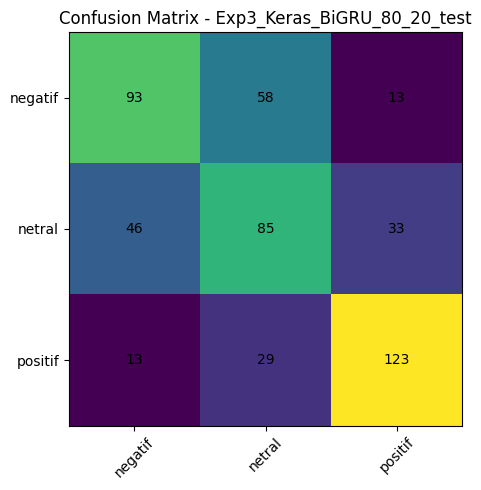

In [15]:
best = max(scores, key=scores.get)
print("Best:", best, "score:", scores[best])

if best == "Exp1_TFIDF_SVM_80_20":
    y_true = y_test
    y_pred = pred_svm
    labels = ["negatif","netral","positif"]
elif best == "Exp2_TFIDF_LR_70_30":
    y_true = y_test2
    y_pred = pred_lr
    labels = ["negatif","netral","positif"]
else:
    y_true = y_test
    y_pred = pred_dl
    labels = ["negatif","netral","positif"]

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title(f"Confusion Matrix - {best}")
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

## 7) Inference (wajib) — input teks → output label

In [18]:
contoh_teks = [
    "Aplikasinya sering error dan bikin emosi",
    "Biasa saja, lumayan buat kebutuhan saya",
    "Mantap! Fiturnya lengkap dan sangat membantu",
    "Netral sih, tapi kadang lemot",
    "Iklan kebanyakan, mengganggu banget"
]

import tensorflow as tf
import numpy as np

def predict_best(texts):
    texts_clean = [clean_text(t) for t in texts]

    if best == "Exp1_TFIDF_SVM_80_20":
        Xv = tfidf_1.transform(texts_clean)
        return svm.predict(Xv)

    if best == "Exp2_TFIDF_LR_70_30":
        Xv = tfidf_2.transform(texts_clean)
        return lr.predict(Xv)

    # Exp3 deep learning (FIX: pakai tf.constant atau list)
    probs = dl.predict(tf.constant(texts_clean, dtype=tf.string), verbose=0)
    ids = probs.argmax(axis=1)
    return np.array([id_to_label[i] for i in ids])

pred = predict_best(contoh_teks)
for t, p in zip(contoh_teks, pred):
    print(f"Teks: {t}\nPrediksi: {p}\n---")

Teks: Aplikasinya sering error dan bikin emosi
Prediksi: negatif
---
Teks: Biasa saja, lumayan buat kebutuhan saya
Prediksi: netral
---
Teks: Mantap! Fiturnya lengkap dan sangat membantu
Prediksi: positif
---
Teks: Netral sih, tapi kadang lemot
Prediksi: positif
---
Teks: Iklan kebanyakan, mengganggu banget
Prediksi: negatif
---
